<center><h1>Modèle RNN - CTCLoss</h1></center>

In [ ]:
#Traitement des mots ou des lignes
data = "lines"#"lines"
#Entraînement du modèle (train=True) ou chargement des poids (Train=False):
train = True

>> I - [Importation des données](#preparation)
>>
>>II - [Prétraitement des données](#pretraitement)
>>
>>III - [Définition du modèle](#model)
>>
>>IV - [Entraînement du modèle](#train)
>>
>>V - [Chargement des poids du modèle](#weights)
>>
>>VI - [Prédictions](#prediction)

- Importation des fichiers et des modules nécessaires.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir database
! mkdir database/ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C database/ascii

#! mkdir database/words
#! tar xzf drive/MyDrive/ocr/database/words.tgz -C database/words
! mkdir database/lines
! tar xzf drive/MyDrive/ocr/database/lines.tgz -C database/lines
! mkdir database/images_test
! cp drive/MyDrive/ocr/database/images_test/* database/images_test/

! cp drive/MyDrive/ocr/src/importation.py importation.py
! cp drive/MyDrive/ocr/src/preprocessor.py preprocessor.py

! mkdir models
! cp drive/MyDrive/ocr/models/* models/

In [ ]:
from importation import Importation
from preprocessor import Preprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Dense, Dropout, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM

# I - <a name="preparation"></a> Importation des données

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


imp = Importation('database')

if data=="words":
    image_width = 128
    image_height = 32
    df = imp.get_words().sample(frac=1, random_state=1).reset_index()
    

if data=="lines":
    image_width = 400
    image_height = 32
    df = imp.get_lines().sample(frac=1, random_state=1).reset_index()
  
df = df[["file", "label"]]
img_size = (image_width, image_height)   
# ensemble des caractères utilisés et taille du plus long mot
max_len, longest_word, characters = imp.get_characters(df.label)
vocab_size = len(characters)

print(f"Nombre d'images à disposition: {len(df)}\n")
if data=="words":
    print(f"Mot le plus long: '{longest_word}', {max_len} caractères\n")
if data=="lines":
    print(f"Ligne la plus longue: '{longest_word}', {max_len} caractères\n")
print(f"Vocabulaire : {vocab_size} caractères \n {sorted(characters)}")

df.head()

Nombre d'images à disposition: 11344

Ligne la plus longue: 'assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .', 93 caractères

Vocabulaire : 79 caractères 
 [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


,file,label
0,database/lines/f04/f04-074/f04-074-06.png,into the path of some train ? This hardly seemed
1,database/lines/g04/g04-039/g04-039-02.png,"where my mother settled , and eventually died ..."
2,database/lines/a01/a01-132/a01-132-08.png,"foods , Mr. Powell said that all these"
3,database/lines/n04/n04-092/n04-092-06.png,"his glass . "" Fill it up , darling . Accuracy ..."
4,database/lines/h07/h07-030/h07-030-08.png,found it more satisfactory to build


# II - <a name="preparation"></a> Prétraitement des données

In [ ]:
batch_size = 64

prepro = Preprocess(img_size, batch_size=batch_size, gaussianBlur=True, max_len=max_len, characters=characters)

# Split des données en un ensemble d'entraînement (90% des données), un ensemble de validation (5%) 
# et un ensemble de test (5%)
df_train, df_valid, df_test = prepro.split_data(df, train_size=0.9)
    
x_train, y_train = df_train["file"].values, df_train["label"].values
x_test, y_test = df_test["file"].values, df_test["label"].values
x_valid, y_valid  = df_valid["file"].values, df_valid["label"].values

# Création des datasets
# redimensionnement des images sans déformation et application d'un filtre gaussian blur
# vectorisation des labels et uniformisation de la longueur :
# vecteur de dimension de la taille du plus long mot (max_len) - token pour compléter : 99


train_ds = prepro.prepare_dataset(x_train, y_train)
validation_ds = prepro.prepare_dataset(x_valid, y_valid)
test_ds = prepro.prepare_dataset(x_test, y_test)

# ensemble de validation pour le calcul de l'edit distance pendant l'entrainement du modèle
if train:
  validation_images, validation_labels = prepro.get_images_labels(validation_ds)

## II.1 - <a name="exemple1"></a> Exemple d'images traitées

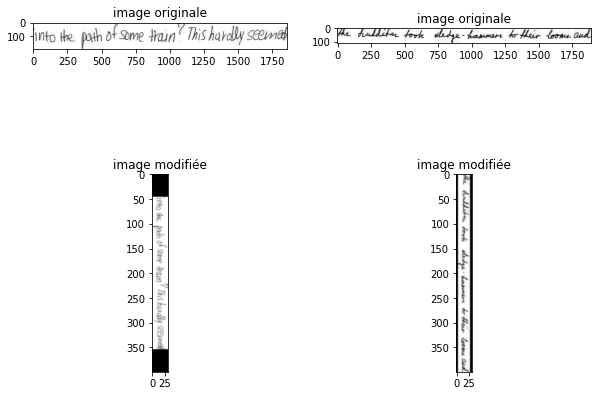

In [ ]:
def traitement_image(image):
  image0 = tf.io.read_file(image)
  image0 = tf.image.decode_png(image0, 1)
  #redimensionnement
  image = prepro.distortion_free_resize(image0, image_height, image_width)
  image = tf.cast(image, tf.float32) / 255.0
  # application filtre
  image = cv2.GaussianBlur(np.squeeze(image.numpy()),(3,3),0)
  return tf.squeeze(image0), image


image1, image1_traitee = traitement_image(x_train[0])
image2, image2_traitee = traitement_image(x_train[27])

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('image originale')
plt.imshow(image1,cmap='gray')
plt.subplot(2,2,3)
plt.title('image modifiée')
plt.imshow(image1_traitee,cmap='gray')
plt.subplot(2,2,2)
plt.title('image originale')
plt.imshow(image2,cmap='gray')
plt.subplot(2,2,4)
plt.title('image modifiée')
plt.imshow(image2_traitee,cmap='gray')
plt.show()

## II.2 - <a name="exemple2"></a> Exemple de vectorisation de labels

In [ ]:
print(f"label: '{y_train[0]}'")     
print(f"label vectorisé: {prepro.vectorize_label(y_train[0])}")       
print(f"label: '{y_train[27]}'")     
print(f"label vectorisé: {prepro.vectorize_label(y_train[27])}")       

label: 'into the path of some train ? This hardly seemed'
label vectorisé: [62 67 73 68  1 73 61 58  1 69 54 73 61  1 68 59  1 72 68 66 58  1 73 71
 54 62 67  1 27  1 47 61 62 72  1 61 54 71 57 65 78  1 72 58 58 66 58 57
 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99
 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
label: 'the Luddites took sledge-hammers to their looms and'
label vectorisé: [73 61 58  1 39 74 57 57 62 73 58 72  1 73 68 68 64  1 72 65 58 57 60 58
 12 61 54 66 66 58 71 72  1 73 68  1 73 61 58 62 71  1 65 68 68 66 72  1
 54 67 57 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99
 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


# III - <a name="model"></a> Définition du modèle

## III.1 - <a name="ctc"></a> Couche CTC Loss


In [ ]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred

## III.2 - <a name="defmodel"></a> Modèle

In [ ]:
# Inputs to the model
input_img = Input(shape=(image_width, image_height, 1), name="image")
labels = Input(name="label", shape=(None,))

# CNNs
x = Conv2D(32,(3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                padding="same",
                name="Conv1"
                )(input_img)
x = MaxPooling2D((2, 2), name="pool1")(x)
x = Conv2D(64,
              (3, 3),
              activation="relu",
              kernel_initializer="he_normal",
              padding="same",
              name="Conv2"
                        )(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

new_shape = ((image_width // 4), (image_height // 4) * 64)
x = Reshape(target_shape=new_shape, name="reshape")(x)

x = Dense(64, activation="relu", name="dense1")(x)
x = dropout = Dropout(0.2)(x)

#RNN
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)
    
x = Dense(vocab_size + 2, activation="softmax", name="dense2")(x)
output = CTCLayer(name='CTCLoss')(labels, x)
    
model = tf.keras.models.Model(
                inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
            )

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt)

model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 400, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 400, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 200, 16, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 200, 16, 64)  18496       ['pool1[0][0

## III.2 - <a name="ctc"></a> Modèle pour prédictions

Modèle pour faire des prédictions - la couche utilsée pour calculer la perte pendant l'entraînement est supprimée

In [ ]:
prediction_model = tf.keras.models.Model(
                 model.get_layer(name="image").input, model.get_layer(name="dense2").output
             )
#prediction_model.summary()

# IV - <a name="train"></a> Entraînement du modèle

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping 

Fonction qui calcule l'edit distance entre un label et sa prédiction

In [ ]:
def calculate_edit_distance(labels, predictions, max_len):
    # Conversion des labels en sparse tensors:
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = tf.keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    predictions_decoded = tf.convert_to_tensor(np.where(predictions_decoded.numpy()==-1,0,predictions_decoded.numpy()))
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, sparse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

CallBack permettant de calculer l'edit distance moyenne à la fin de chaque époque

In [ ]:
class EditDistanceCallback(Callback):
    def __init__(self, pred_model, max_len, distances, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.max_len = max_len
        self.validation_images = validation_images
        self.validation_labels = validation_labels
        self.distances = distances

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            predictions = self.prediction_model.predict(self.validation_images[i], verbose=0)
            # Remplacement du padding-token 99 en 0 pour utilisation des sparse tensors dans le calcul
            # de l'edit distance 
            t = tf.convert_to_tensor(np.where(labels.numpy()==99,0,labels.numpy()))
            edit_distances.append(calculate_edit_distance(t, predictions, self.max_len).numpy())
        self.distances.append(np.mean(edit_distances))
        print(
            f" Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )    
      

In [ ]:
def train_model(train_ds, validation_ds, epochs, validation_images, validation_labels, verbose=1):
    
    distances = []
    edit_distance_callback = EditDistanceCallback(
        prediction_model, 
        max_len,
        distances, 
        validation_images, 
        validation_labels)
    
    early_stopping = EarlyStopping(monitor = 'val_loss',
                  min_delta = 0.01,
                  patience = 5,
                  mode= 'min',
                  verbose = 1)
    # Train the model.
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        #callbacks=[edit_distance_callback, early_stopping],
        callbacks=[edit_distance_callback],
        verbose=verbose
    )
    return history, distances

Epoch 1/150
160/160 [==============================] - 107s 553ms/step - loss: 141.8418 - val_loss: 134.5270
Epoch 2/150
160/160 [==============================] - 20s 126ms/step - loss: 134.3347 - val_loss: 134.1369
Epoch 3/150
160/160 [==============================] - 20s 127ms/step - loss: 133.7675 - val_loss: 130.9930
Epoch 4/150
160/160 [==============================] - 20s 127ms/step - loss: 121.7868 - val_loss: 114.1359
Epoch 5/150
160/160 [==============================] - 20s 125ms/step - loss: 107.3908 - val_loss: 97.5320
Epoch 6/150
160/160 [==============================] - 20s 124ms/step - loss: 96.1116 - val_loss: 88.4374
Epoch 7/150
160/160 [==============================] - 22s 135ms/step - loss: 88.7166 - val_loss: 80.8231
Epoch 8/150
160/160 [==============================] - 20s 125ms/step - loss: 82.5667 - val_loss: 75.0519
Epoch 9/150
160/160 [==============================] - 20s 124ms/step - loss: 77.8229 - val_loss: 69.6028
Epoch 10/150
160/160 [==============

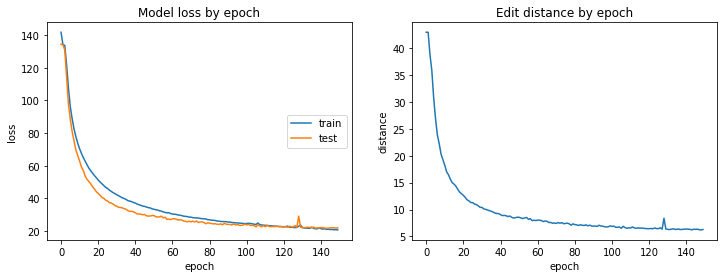

In [ ]:
assert train


if data=="words":
  epochs = 100
if data=="lines":
  epochs = 150


history, distance = train_model(
        train_ds, validation_ds, epochs, validation_images, validation_labels, verbose=1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.subplot(122)
plt.plot(distance)
plt.title('Edit distance by epoch')
plt.ylabel('distance')
plt.xlabel('epoch')
    
plt.show()

Enregistrement des poids du modèle entraîné

In [ ]:
assert train
if data=="words":
    model.save_weights('model_ctc_words_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.h1')
if data=="lines":
    model.save_weights('model_ctc_lines_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.h1')

# V - <a name="weights"></a> Chargement des poids du modèle

In [ ]:
assert not train

if data=="words":
  model.load_weights("models/model_ctc_words.h1")
if data=="lines":
  model.load_weights("models/model_ctc_lines.h1")

# VI - <a name="prediction"></a> Prédictions

Focntion pour décoder la prédiction issue du modèle

In [ ]:
# retourne le texte en fonction du vecteur
def decode_to_text(vect):
    text = []
    for res in vect:
            res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
            res = tf.strings.reduce_join(prepro.num_to_char(res)).numpy().decode("utf-8")
            text.append(res)
    return text
    
def get_prediction(ds, normalize=True):
    edit_distances = []
    output_text = []
    for batch in ds:
        label = batch['label']
        label = np.where(label.numpy()==99,0,label.numpy())
        sparse_labels = tf.cast(tf.sparse.from_dense(label), dtype=tf.int64)    
        batch_images = batch["image"]
        preds = prediction_model.predict(batch_images, verbose=0)
        input_len = np.ones(preds.shape[0]) * preds.shape[1]
        #décodage de la sortie du modèle (best_path)
        predictions_decoded = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][
            :, :max_len
        ]
        
        #prédiction du modèle décodée en texte
        text = decode_to_text(predictions_decoded)
        output_text += text    
            
        # Calcule de la distance entre le label et sa prédiction    
        predictions_decoded = np.where(predictions_decoded.numpy()==-1,0,predictions_decoded.numpy())
        sparse_predictions = tf.cast(
            tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
        )
        distance = tf.edit_distance(sparse_predictions, sparse_labels, normalize=normalize)
        edit_distances.append(distance.numpy())
    
    return output_text, np.concatenate(edit_distances).tolist()

# Création d'un dataset pour une image unique
def get_ds(img_path, label):
    x = np.array([img_path])
    y = np.array([label])
    ds = prepro.prepare_dataset(x, y)
    return ds

## VI-1 - <a name="prediction10"></a> Prédiction sur 10 images tirées au hasard dans l'ensemble de test

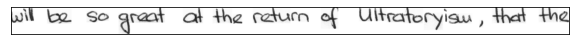

Label     : will be so great at the return of Ultratoryism , that the
Prédiction: wil be so great at the return of Utractoryiou , that the
Edit distance: 5.0 / Edit distance normalisée: 0.09


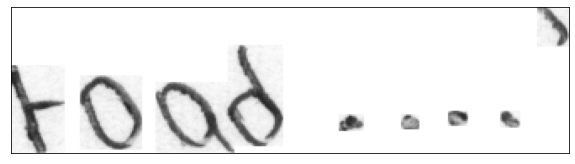

Label     : road ... . '
Prédiction: toad . . '
Edit distance: 3.0 / Edit distance normalisée: 0.25


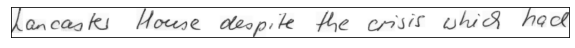

Label     : Lancaster House despite the crisis which had
Prédiction: Mancaster House despite the crisis which had
Edit distance: 1.0 / Edit distance normalisée: 0.02


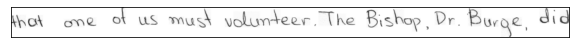

Label     : that one of us must volunteer . The Bishop , Dr. Burge , did
Prédiction: thot one of us must voderteer . The Bistap , Mr. Burge , did
Edit distance: 7.0 / Edit distance normalisée: 0.12


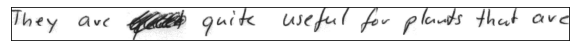

Label     : They are # quite useful for plants that are
Prédiction: They are gleet quite weful for plants that are
Edit distance: 7.0 / Edit distance normalisée: 0.16


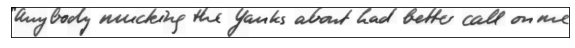

Label     : " Anybody mucking the Yanks about had better call on me
Prédiction: ngbaty nurcding the Gantes about had better call onsme
Edit distance: 13.0 / Edit distance normalisée: 0.24


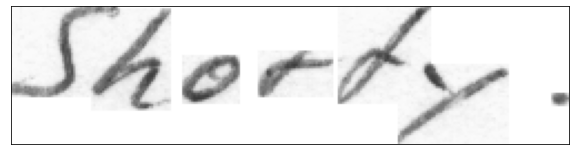

Label     : Shorty .
Prédiction: shordy .
Edit distance: 2.0 / Edit distance normalisée: 0.25


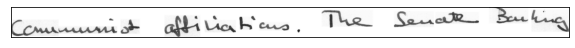

Label     : Communist affiliations . The Senate Banking
Prédiction: communinst offiviations . The Samate Benting
Edit distance: 8.0 / Edit distance normalisée: 0.19


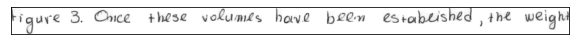

Label     : Figure 3 . Once these volumes have been established , the weight
Prédiction: Figuse s Cne those velumes have been esvabeiated , ihe veight
Edit distance: 14.0 / Edit distance normalisée: 0.22


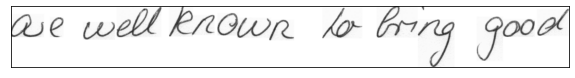

Label     : are well known to bring good
Prédiction: wre well brown to bring good
Edit distance: 3.0 / Edit distance normalisée: 0.11


In [ ]:
#from PIL import Image
files = []
labels = []
predictions = []
distances = []
df_predict = df_test
for i in np.random.choice(np.arange(0, len(df_predict)), size=10):       
    label = df_predict.iloc[i].label
    img_path = df_predict.iloc[i].file
    ds = get_ds(img_path, label)
    prediction, distance = get_prediction(ds, normalize=False)
    image = cv2.imread(img_path)
    plt.figure(figsize=(10,3))
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print(f"Label     : {label}")
    print(f"Prédiction: {prediction[0]}")
    print(f"Edit distance: {distance[0]} / Edit distance normalisée: {np.round(distance[0]/len(label),2)}")
    #print("\n")
    files.append(img_path)
    labels.append(label)
    predictions.append(prediction)
    distances.append(distance)



## VI-2 - <a name="predictiontest"></a> Prédiction sur tout l'ensemble test - edit distance moyenne - accuracy

In [ ]:
ds = test_ds
output_text, edit_distances = get_prediction(ds, normalize=False)

        
df_result = pd.DataFrame({'file' : x_test,
                          'label' : y_test,
                          'prediction' : output_text,
                          'distance' : edit_distances
                         })

df_result['distance normalisée'] = np.round(df_result['distance'] /  df_result['label'].apply(lambda x : len(x)),2)

df_result[["label", "prediction", "distance", "distance normalisée"]].head()


,label,prediction,distance,distance normalisée
0,so as to make it grow . He does not,so as to maln it proes . He does not,5.0,0.14
1,expect the total to leap to,expect the lelel t leayp a,8.0,0.30
2,"membership of eight million was a "" poor","membership of eight million was a , poor",1.0,0.02
3,present state of the Gospel is the result of a...,preent ctiatk of the coapend in the conls ot ...,33.0,0.43
4,"understand , but an express took him off yeste...","understand , but on expess took him off yester...",4.0,0.07


In [ ]:
df_result[["distance", "distance normalisée"]].mean()

distance               6.663732
distance normalisée    0.151637
dtype: float64

In [ ]:

accuracy = df_result[df_result.distance==0].shape[0]/df_result.shape[0]
print(f"Pourcentage lignes reconnues exactement : {round(100*accuracy,2)}%")

Pourcentage lignes reconnues exactement : 5.46%
